In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from metrics import MCC

In [2]:
# Model name used to save the weights in h5 format. The name match with the Jupyter notebook
now = datetime.datetime.now()

MODEL_NAME = 'malaria_model_' + now.strftime('%Y%m%d%H%M')
print(MODEL_NAME)

malaria_model_201906170855


In [3]:
# DATA PATHS

TRAIN_FOLDER_PATH = '../../data/train/'
VAL_FODLER_PATH = '../../data/validation/'
#TEST_FOLDER_PATH = '../../data/test/'
TEST_FOLDER_PATH = '../../data/test_manual'
PREVIEW_IMAGES_FOLDER = '../../data/preview/'

PREDICTION_FILE_PATH = '../../data/' + MODEL_NAME + '.csv'

In [4]:
# Configure hyperparameters
img_width = 100
img_height = 100
img_depth = 3

classes = 2
batch_size = 64
num_epochs = 60
loss = "categorical_crossentropy"
learning_rate = 1e-1
decay = 1e-1
momentum = 0.9

In [5]:
# MODEL TRAINING CONFIGURATION

train_datagen = ImageDataGenerator(
    rescale=1 / 255.0,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode="nearest"
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_FOLDER_PATH,
    target_size = (img_height,img_width),
    color_mode='rgb',
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True
)

validation_generator = validation_datagen.flow_from_directory(
    VAL_FODLER_PATH,
    target_size = (img_height, img_width),
    color_mode='rgb',
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

test_generator = test_datagen.flow_from_directory(
    TEST_FOLDER_PATH,
    target_size = (img_height, img_width),
    color_mode='rgb',
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

Found 20668 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.
Found 1376 images belonging to 2 classes.


In [6]:
# Model architecture

inputShape = (img_height, img_width, img_depth)

model = Sequential()

model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(classes))
model.add(Activation("softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 50, 50, 64)        0

In [7]:
# Callbacks
mc = ModelCheckpoint('best_' + MODEL_NAME + '.h5', monitor='val_MCC', mode='max', verbose=1, save_best_only=True)
es = EarlyStopping(monitor = 'val_MCC', patience=10, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateu(patience=2)

In [8]:
# Compile the model
opt = SGD(lr=learning_rate, momentum=momentum, decay=decay / num_epochs)

model.compile(loss=loss, optimizer = opt, metrics=["accuracy", MCC])

In [9]:
# Fit the model
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.n // train_generator.batch_size,
    epochs = num_epochs,
    validation_data = validation_generator,
    validation_steps = validation_generator.n // validation_generator.batch_size,
    use_multiprocessing = False,
    workers=1,
    callbacks = [mc, es]
)

Epoch 1/60


W0617 08:55:23.007708 140234074683200 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


321/322 [============================>.] - ETA: 0s - loss: 0.8037 - accuracy: 0.7510 - MCC: 0.5019
Epoch 00001: val_MCC improved from -inf to 0.81831, saving model to best_malaria_model_201906170855.h5
322/322 [==============================] - 52s 160ms/step - loss: 0.8019 - accuracy: 0.7515 - MCC: 0.5030 - val_loss: 0.2398 - val_accuracy: 0.9092 - val_MCC: 0.8183
Epoch 2/60
321/322 [============================>.] - ETA: 0s - loss: 0.1928 - accuracy: 0.9357 - MCC: 0.8715
Epoch 00002: val_MCC improved from 0.81831 to 0.87173, saving model to best_malaria_model_201906170855.h5
322/322 [==============================] - 49s 151ms/step - loss: 0.1926 - accuracy: 0.9359 - MCC: 0.8718 - val_loss: 0.1857 - val_accuracy: 0.9359 - val_MCC: 0.8717
Epoch 3/60
321/322 [============================>.] - ETA: 0s - loss: 0.1706 - accuracy: 0.9443 - MCC: 0.8885
Epoch 00003: val_MCC did not improve from 0.87173
322/322 [==============================] - 49s 151ms/step - loss: 0.1707 - accuracy: 0.944

321/322 [============================>.] - ETA: 0s - loss: 0.1246 - accuracy: 0.9591 - MCC: 0.9182
Epoch 00024: val_MCC did not improve from 0.92769
322/322 [==============================] - 47s 147ms/step - loss: 0.1244 - accuracy: 0.9592 - MCC: 0.9184 - val_loss: 0.1139 - val_accuracy: 0.9637 - val_MCC: 0.9273
Epoch 25/60
321/322 [============================>.] - ETA: 0s - loss: 0.1240 - accuracy: 0.9584 - MCC: 0.9168
Epoch 00025: val_MCC improved from 0.92769 to 0.92878, saving model to best_malaria_model_201906170855.h5
322/322 [==============================] - 49s 152ms/step - loss: 0.1241 - accuracy: 0.9584 - MCC: 0.9168 - val_loss: 0.1226 - val_accuracy: 0.9644 - val_MCC: 0.9288
Epoch 26/60
321/322 [============================>.] - ETA: 0s - loss: 0.1230 - accuracy: 0.9588 - MCC: 0.9176
Epoch 00026: val_MCC did not improve from 0.92878
322/322 [==============================] - 49s 151ms/step - loss: 0.1234 - accuracy: 0.9587 - MCC: 0.9175 - val_loss: 0.1120 - val_accuracy: 

321/322 [============================>.] - ETA: 0s - loss: 0.1150 - accuracy: 0.9637 - MCC: 0.9275
Epoch 00048: val_MCC did not improve from 0.93205
322/322 [==============================] - 49s 152ms/step - loss: 0.1151 - accuracy: 0.9637 - MCC: 0.9273 - val_loss: 0.1038 - val_accuracy: 0.9646 - val_MCC: 0.9291
Epoch 49/60
321/322 [============================>.] - ETA: 0s - loss: 0.1165 - accuracy: 0.9612 - MCC: 0.9224
Epoch 00049: val_MCC improved from 0.93205 to 0.93241, saving model to best_malaria_model_201906170855.h5
322/322 [==============================] - 49s 152ms/step - loss: 0.1167 - accuracy: 0.9612 - MCC: 0.9223 - val_loss: 0.1036 - val_accuracy: 0.9662 - val_MCC: 0.9324
Epoch 50/60
321/322 [============================>.] - ETA: 0s - loss: 0.1154 - accuracy: 0.9616 - MCC: 0.9233
Epoch 00050: val_MCC did not improve from 0.93241
322/322 [==============================] - 48s 150ms/step - loss: 0.1155 - accuracy: 0.9616 - MCC: 0.9232 - val_loss: 0.1012 - val_accuracy: 

In [10]:
# Save model
model.save_weights(MODEL_NAME + '.h5')

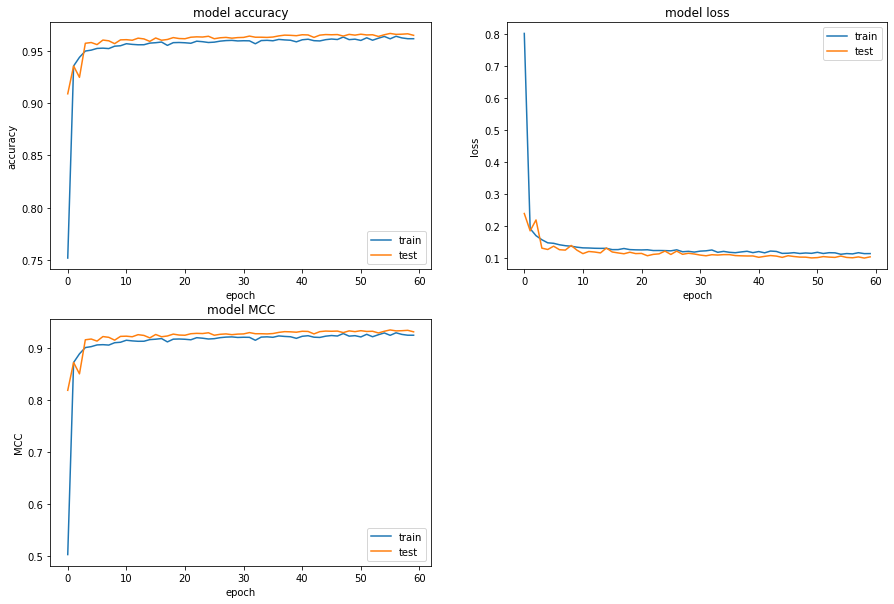

In [23]:
# Plot accuracy and loss values
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
#plt.show()
# summarize history for loss
plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

# Plot MCC values
plt.subplot(2,2,3)
plt.plot(history.history['MCC'])
plt.plot(history.history['val_MCC'])
plt.title('model MCC')
plt.ylabel('MCC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [12]:
# Evaluate the model
model.evaluate_generator(validation_generator, steps = validation_generator.n // validation_generator.batch_size)

[0.10455750419520014, 0.96529794, 0.93059593]

In [13]:
# Predictions

test_generator.reset()
predIdxs = model.predict_generator(test_generator,steps=(test_generator.n // test_generator.batch_size) + 1)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [14]:
# Show metrics

print(classification_report(test_generator.classes, predIdxs, target_names=test_generator.class_indices.keys()))

cm = confusion_matrix(test_generator.classes, predIdxs)
total = sum(sum(cm))
acc = (cm[0,0] + cm[1,1]) / total
sensitivity = cm[0,0] / (cm[0,0] + cm[0,1])
specificity = cm[1,1] / (cm[1,0] + cm[1,1])

print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

              precision    recall  f1-score   support

 parasitized       0.97      0.95      0.96       688
  uninfected       0.95      0.97      0.96       688

    accuracy                           0.96      1376
   macro avg       0.96      0.96      0.96      1376
weighted avg       0.96      0.96      0.96      1376

acc: 0.9608
sensitivity: 0.9520
specificity: 0.9695
